In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# set working dictionary
import os
import sys

WORKSPACEK = '/content/drive/MyDrive/Capstone/Workspace/drl-stock-trading/stock-price-predictor'
SRC = f'{WORKSPACEK}/src' 
DATA =f'{WORKSPACEK}/data' 
OUTPUT =f'{WORKSPACEK}/output' 
model =f'{WORKSPACEK}/model' 

os.chdir(SRC)
sys.path.append(SRC)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Config

In [4]:
##########################
# Parameters
##########################

# Input
ALGORITHM = "LSTM"
MODEL = "3L_2F"
VERSION = "v1"

MODEL_NAME = f"{ALGORITHM}_{MODEL}_{VERSION}"

# Model parameter
Break_Date = '2010-01-01'
EPOCH = 200

STOCK_NAME = "GE"

##########################
# Meta
##########################

OUTPUT_FOLDER = f"{OUTPUT}/{MODEL_NAME}"

if not os.path.exists(OUTPUT_FOLDER):
  os.makedirs(OUTPUT_FOLDER)
 

# Input prepare
INPUT_FILE = f"{DATA}/{STOCK_NAME}.csv"
STOCK  = pd.read_csv(f"{INPUT_FILE}")

TIMESTAMP = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

##########################
# Print 
##########################
print("=====================================================================")
print(f"TIMESTAMP:    {TIMESTAMP}")
print(f"MODEL_NAME:    {MODEL_NAME}")
print(f"Break_Date:    {Break_Date}")
print(f"EPOCH:       {EPOCH}")
print(f"OUTPUT_FOLDER:   {OUTPUT_FOLDER}")
print("=====================================================================")

TIMESTAMP:    2022_03_29_01_23_05
MODEL_NAME:    LSTM_3L_2F_v1
Break_Date:    2010-01-01
EPOCH:       200
OUTPUT_FOLDER:   /content/drive/MyDrive/Capstone/Workspace/drl-stock-trading/stock-price-predictor/output/LSTM_3L_2F_v1


## Run

In [5]:
def Dataset(Data, Date):
    Train_Data = Data['Adj. Close'][Data['Date'] < Date].to_numpy()
    Data_Train = []
    Data_Train_X = []
    Data_Train_Y = []
    for i in range(4, len(Train_Data)-2):
        try:
            Data_Train_X.append(Train_Data[i-4: i+1])
            Data_Train_Y.append(Train_Data[i-3: i+2])
        except:
            pass

    #if len(Data_Train[-1]) < 5:
    #    Data_Train.pop(-1)

    #Data_Train_X = Data_Train[0: -1]
    Data_Train_X = np.array(Data_Train_X)
    Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
    #Data_Train_Y = Train_Data[1: len(Train_Data)]
    Data_Train_Y = np.array(Data_Train_Y)
    Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))

    Test_Data = Data['Adj. Close'][Data['Date'] >= Date].to_numpy()
    Data_Test = []
    Data_Test_X = []
    Data_Test_Y = []
    for i in range(4, len(Test_Data)-2):
        try:
            #Data_Test.append(Test_Data[i-4: i+1])
            Data_Test_X.append(Test_Data[i - 4: i + 1])
            Data_Test_Y.append(Test_Data[i - 3: i + 2])
        except:
            pass

    #if len(Data_Test[-1]) < 5:
    #    Data_Test.pop(-1)

    #Data_Test_X = Data_Test[0: -1]
    Data_Test_X = np.array(Data_Test_X)
    Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
    #Data_Test_Y = Data_Test[1: len(Data_Test)]
    Data_Test_Y = np.array(Data_Test_Y)
    Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

    return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

def Model():
  model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
        tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
        tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
        tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
        tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
        tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
        ])
  return model

model = Model()

def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Change Dtype of Date column
STOCK["Date"] = pd.to_datetime(STOCK["Date"])

# Dataset
# #param  1: Stock price, series
# #param  2: Training, Testing: break point 
Train_X, Train_Y, Test_X, Test_Y = Dataset(STOCK, Break_Date)

Model = Model()

Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

hist = Model.fit(Train_X, Train_Y, epochs = EPOCH, validation_data = (Test_X, Test_Y), callbacks=[callback])


######################
# Post Train
######################
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)


 


Epoch 1/200
40/40 [==============================] - 6s 41ms/step - loss: 23523.0020 - root_mean_squared_error: 153.3721 - val_loss: 19528.9668 - val_root_mean_squared_error: 139.7461 - lr: 0.0000e+00
Epoch 2/200
40/40 [==============================] - 1s 29ms/step - loss: 23522.5449 - root_mean_squared_error: 153.3706 - val_loss: 19528.1680 - val_root_mean_squared_error: 139.7432 - lr: 6.6667e-08
Epoch 3/200
40/40 [==============================] - 1s 29ms/step - loss: 23521.1270 - root_mean_squared_error: 153.3660 - val_loss: 19526.5605 - val_root_mean_squared_error: 139.7375 - lr: 1.3333e-07
Epoch 4/200
40/40 [==============================] - 1s 29ms/step - loss: 23518.7402 - root_mean_squared_error: 153.3582 - val_loss: 19524.1270 - val_root_mean_squared_error: 139.7287 - lr: 2.0000e-07
Epoch 5/200
40/40 [==============================] - 1s 33ms/step - loss: 23515.4160 - root_mean_squared_error: 153.3474 - val_loss: 19520.8965 - val_root_mean_squared_error: 139.7172 - lr: 2.6667

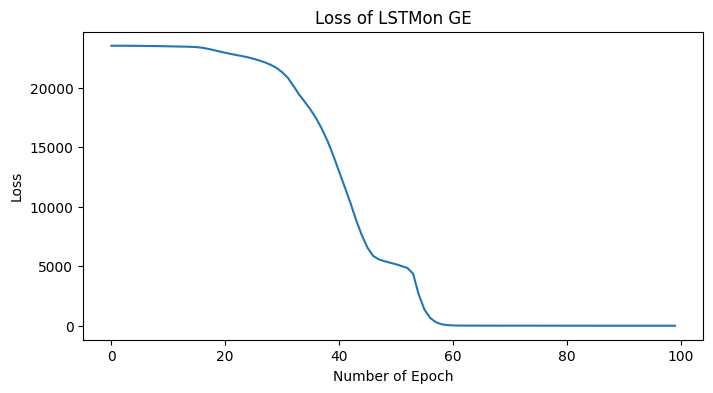

In [14]:
import matplotlib.pyplot as plt
plt.style.use('default')

######################
# Plot loss chart 
######################

def plot_loss(loss, title):
    ax = plt.figure(figsize=(8, 4))  
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Number of Epoch')
    plt.plot(np.arange(len(loss)), loss)
    plt.show()


plot_loss(loss[:100], "Loss of LSTMon GE")

In [ ]:
######################
# Prediction
######################
prediction = Model.predict(Test_X)


rmse = math.sqrt(mean_squared_error(Test_Y.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - Test_Y.reshape(-1, 5))/np.abs(Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


######################
# Write Output
######################


for i in range(1, 6):
  STOCK[f'Predict{i}'] = 0
  STOCK[f'Predict{i}'][-1 * len(prediction):] = [x[i-1] for x in prediction]

file_name = f"{OUTPUT_FOLDER}/{STOCK_NAME}_{TIMESTAMP}_predict.csv"

print(f"Write date into file {file_name}")
STOCK.to_csv(file_name, index=False)


######################
# Write log 
######################

with open(f"{OUTPUT_FOLDER}/{STOCK_NAME}_{TIMESTAMP}_README.txt", "w") as f:
  f.write(f"MODEL_NAME:    {MODEL_NAME}\n")
  f.write(f"Break_Date:    {Break_Date}\n")
  f.write(f"EPOCH:       {EPOCH}\n")
  f.write(f"STOCK_NAME:    {STOCK_NAME}\n")

  f.write(f">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\n")
  f.write(f'RMSE: {rmse}\n')
  f.write(f'MAPE: {mape}\n')